# How to get started

## Imports
All module imports are performed below. Make sure you have the required dependables installed (see requirements.txt for details).

In [1]:
import numpy as np
import shutup; shutup.please()   # shut up warnings
import torch

# own
from frameworks.frameworkFSL import FrameworkFSL
from frameworks.frameworkLCM import FrameworkLCModel
from simulation.dataModules import ChallengeDataModule, SynthDataModule, InVivoDataModule
from train import Pipeline
from visualizations.plotFunctions import *

## Initialization
The config dictionary below holds all relevant settings for the experiments, it is generally used to set up training of the network as well as testing scenarios.

In [2]:
config = {
    # path to a trained model
    'path2trained': './lightning_logs/sskt2pvt/checkpoints/epoch=0-step=1195264.ckpt',

    # path to basis set
    'path2basis': '../Data/BasisSets/ISMRM_challenge/basisset_JMRUI/',  # path to basis set

    # for nn models
    'arch': 'unet',   # 'unet', ...
    'specType': 'synth',   # 'auto', 'synth', 'invivo', 'biggaba', 'fMRSinPain'
    'basisFmt': '',  # '', 'cha_philips', 'biggaba', 'fMRSinPain'

    # for lcm model
    'method': 'Newton',   # 'Newton', 'MH', 'LCModel'
    'ppmlim': (0.5, 4.2),  # ppm limits for the spectra

    # data settings
    'dataType': 'norm_rw_p',   # 'cha', 'clean', 'norm', 'norm_rw', 'norm_rw_p', 'custom', ...
    'note': 'norm_rw_p',   # additional note

    'test_size': 1,   # number of test samples
    'load_model': True,   # load model from path2trained
    'skip_train': True,   # skip the training procedure

    # plot settings
    'idx': [0],   # select sample index
    'metIdx': [],   # metabolite index to plot
    'imag': False,   # plot imaginary or real part
}

## Pipeline
Following we set up the pipeline, this step assures we initialize everything optimally and as specified above. After which the correspodning data is loaded with the required dataloader.

In [3]:
# initialize pipeline
pipeline = Pipeline()
pipeline.default_config.update(config)   # config is passed to pipeline
pipeline.main({'online': False})

# get decomposition model and final config
config, model = pipeline.config, pipeline.model

Global seed set to 42


     memory
GPU        
0      1041
1     11070
2     10655
Selected GPU 1 with 11070 MiB of memory available


Lightning automatically upgraded your loaded checkpoint from v1.9.2 to v2.0.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file A:\projects\Scalograms\WAND\Code\lightning_logs\sskt2pvt\checkpoints\epoch=0-step=1195264.ckpt`


## Data Loading

In [4]:
# load test data
if config.dataType[:3] == 'cha':
    dataloader = ChallengeDataModule(basis_dir=config.path2basis,
                                     nums_cha=config.test_size)
else:
    dataloader = SynthDataModule(basis_dir=config.path2basis,
                                 nums_test=config.test_size,
                                 sigModel=model.sigModel,
                                 params=model.ps,
                                 concs=model.concs,
                                 basisFmt=config.basisFmt,
                                 specType=config.specType)

data = next(iter(dataloader.test_dataloader()))
x, y, t = data
model = model.to(x.device)

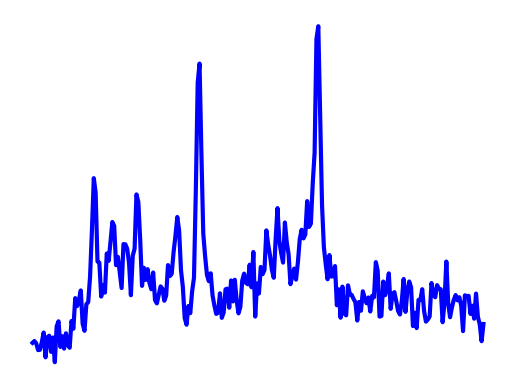

In [5]:
# visualize example spectrum
for i in config.idx: plot_spectra(x[i, :, model.first:model.last])

## Running the Wavelet Analysis-based Neural Decomposition (WAND)
Running the method on the loaded data: first the mean is subtracted from spectra, then pushed through the network...

In [6]:
# inference
xn, yn, t = model.prepareData(x, y
                              , t)  # remove DC component
y_hat, ms = model.forward(xn)
cwtmatr, masks = ms
xs = xn[:, :, model.first:model.last:model.skip]
if config.dataType[:6] == 'invivo': ys = None
else: ys = yn[:, :, model.first:model.last:model.skip]

## Visualization

['Ace', 'Ala', 'Asc', 'Asp', 'Cr', 'GABA', 'Glc', 'Gln', 'Glu', 'Gly', 'GPC', 'GSH', 'Ins', 'Lac', 'Mac', 'NAA', 'NAAG', 'PCho', 'PCr', 'PE', 'sIns', 'Tau', 'baseline', 'artifacts']


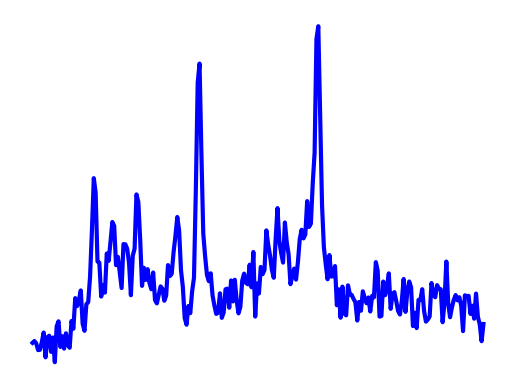

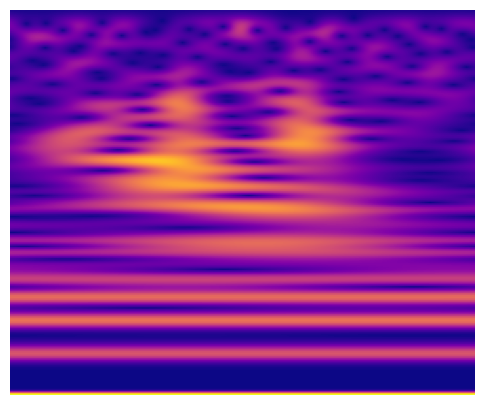

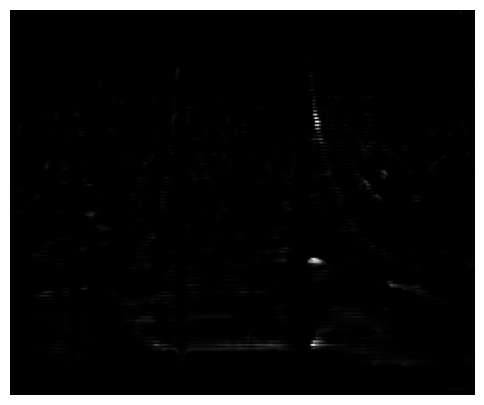

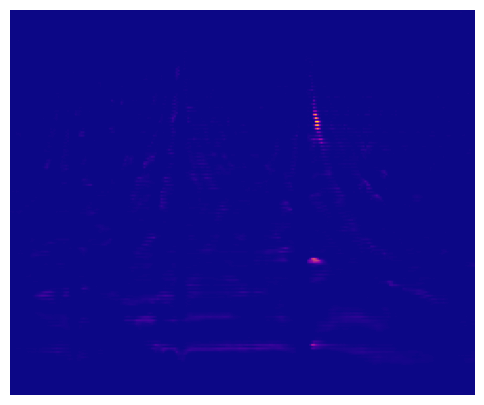

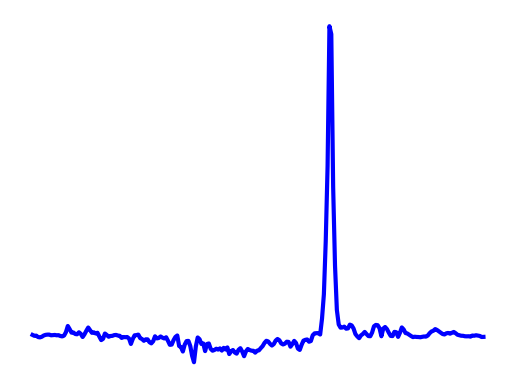

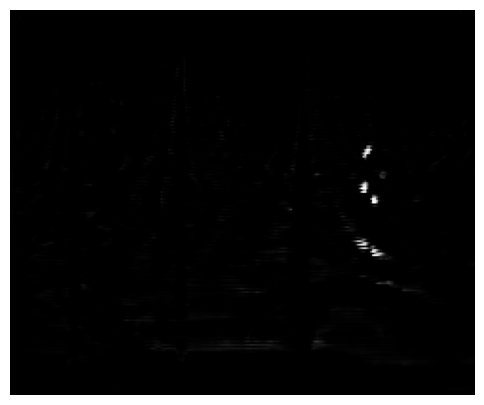

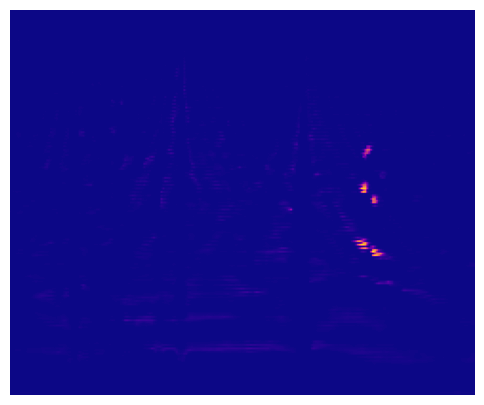

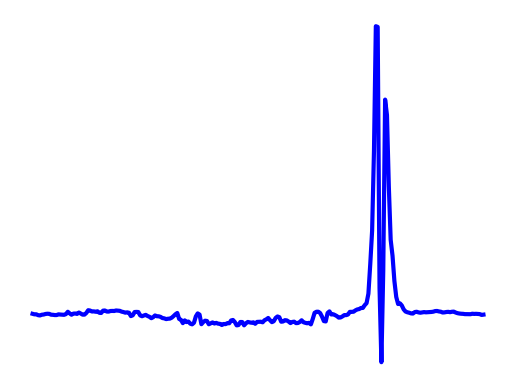

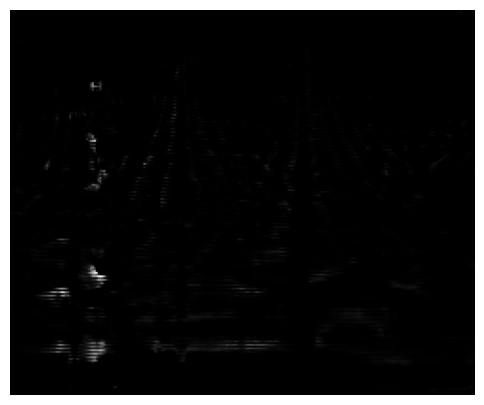

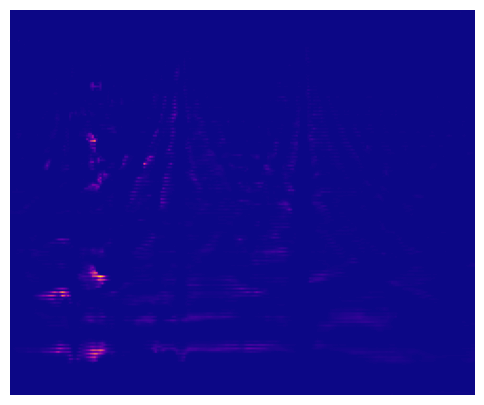

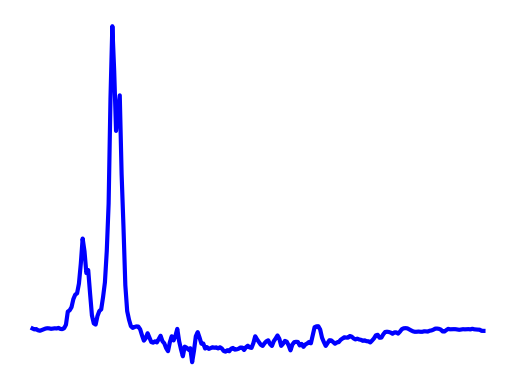

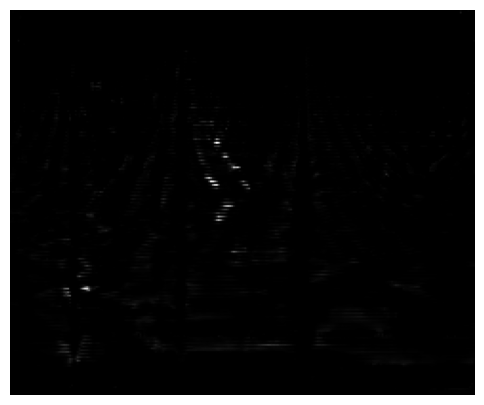

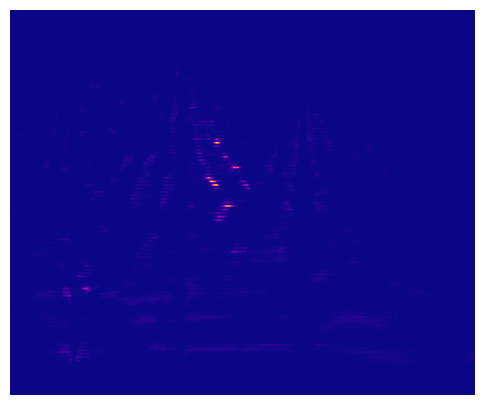

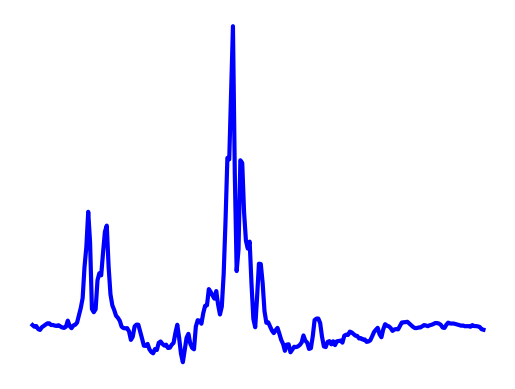

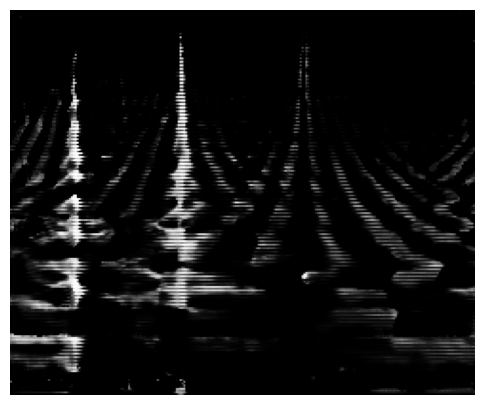

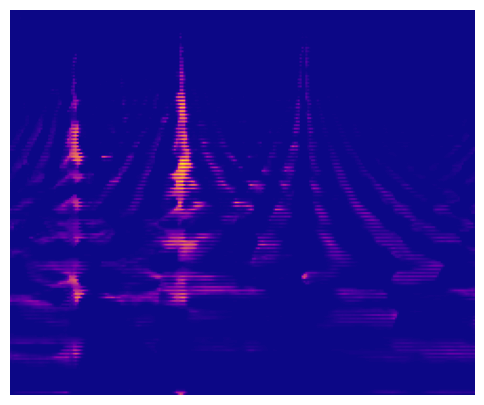

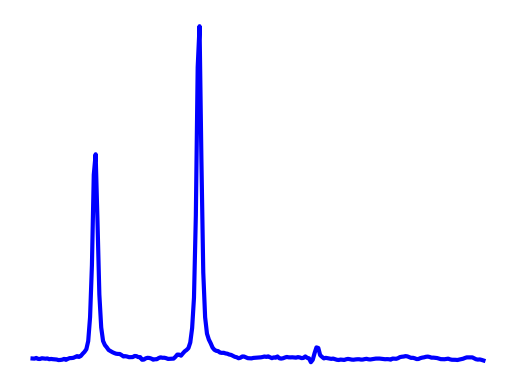

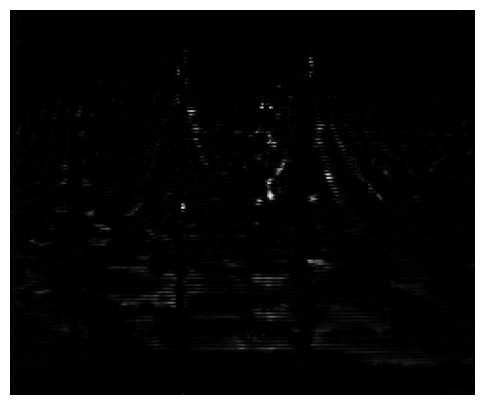

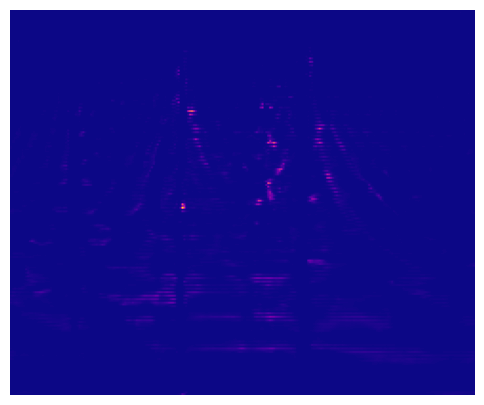

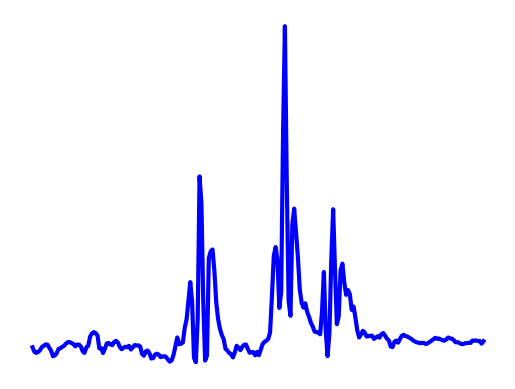

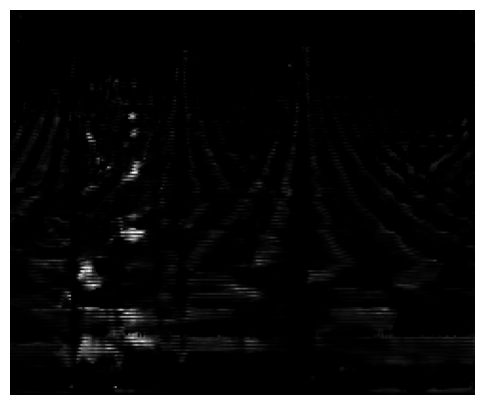

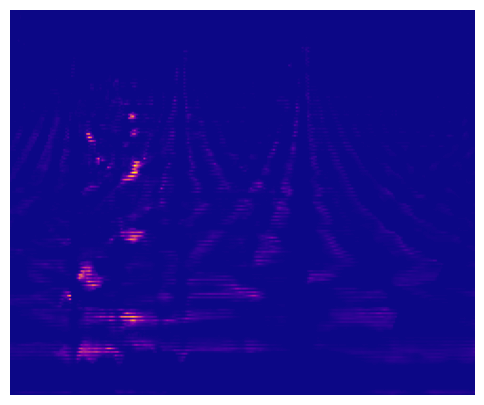

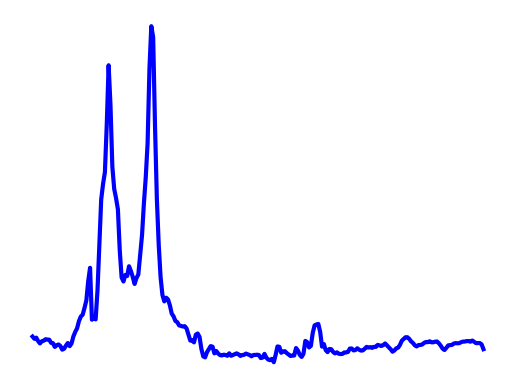

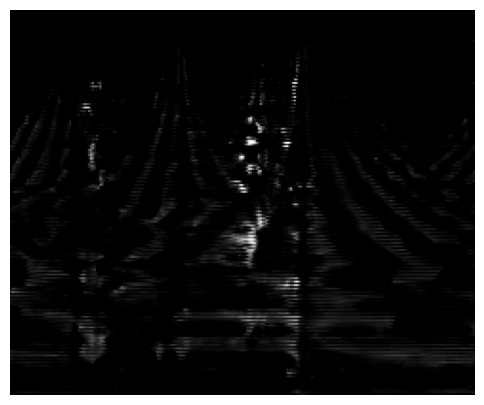

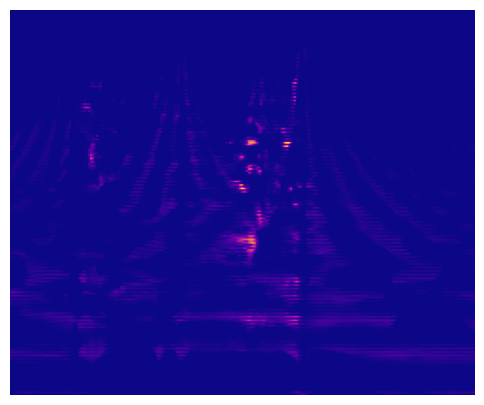

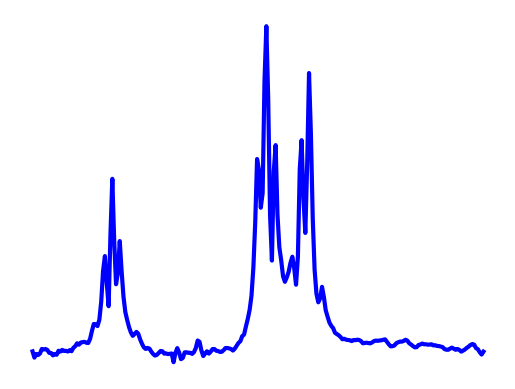

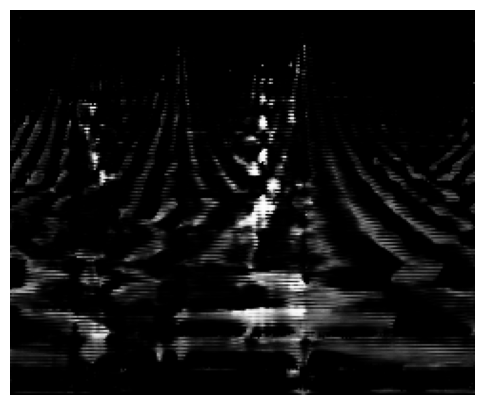

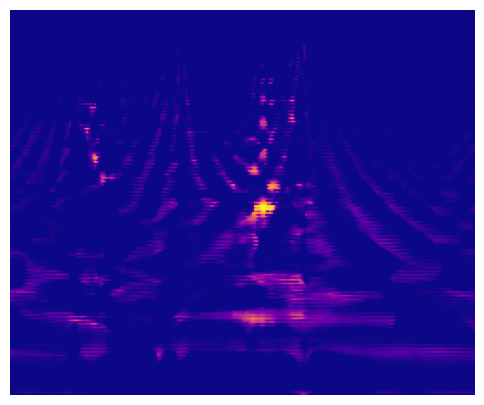

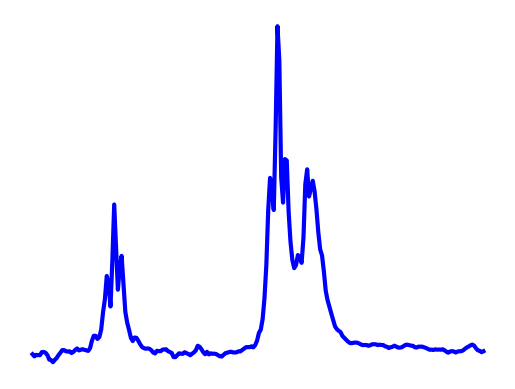

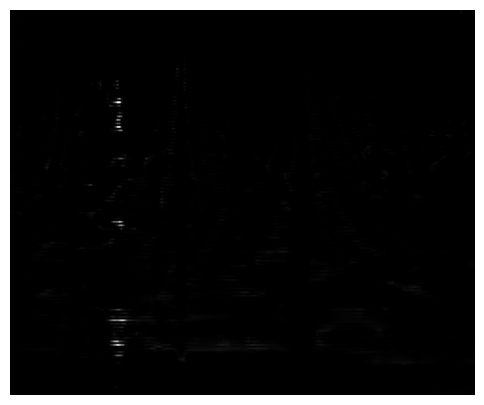

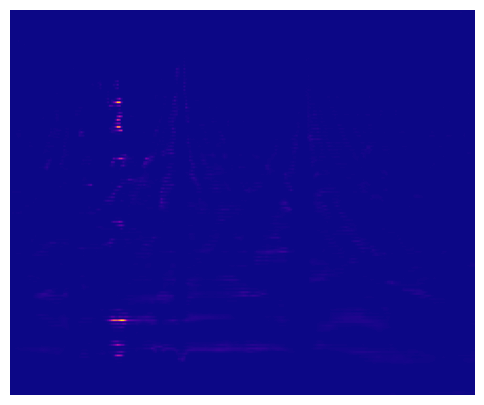

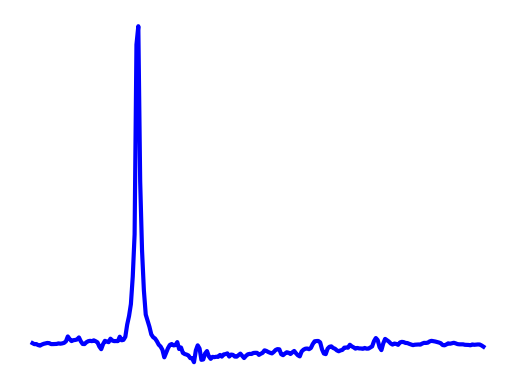

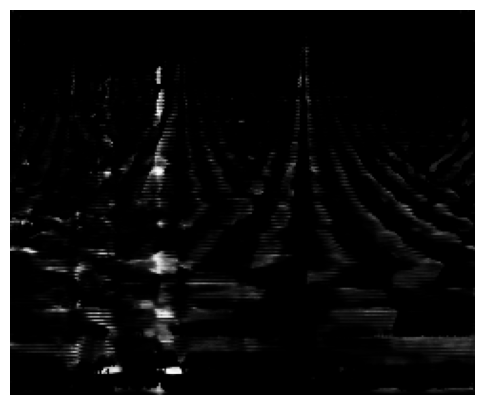

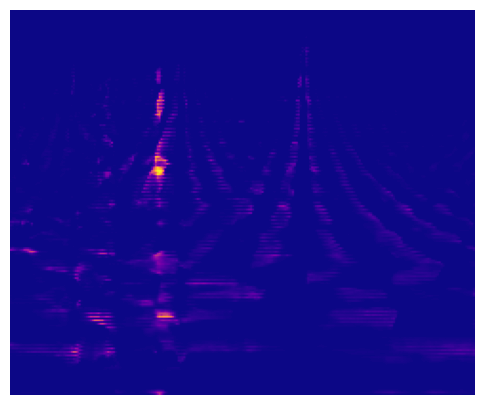

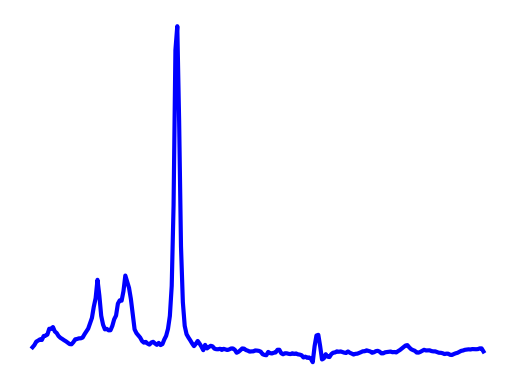

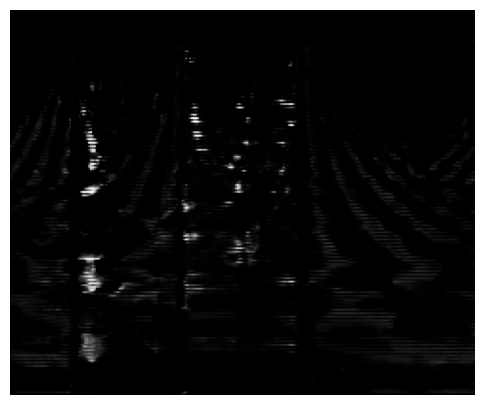

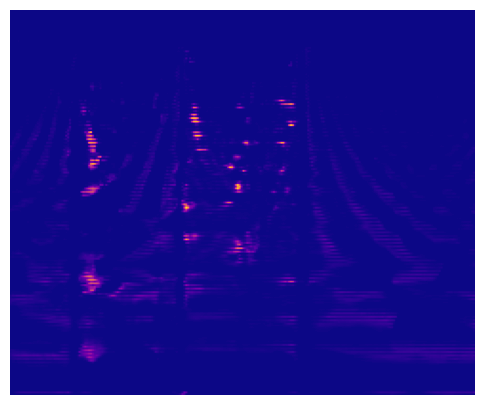

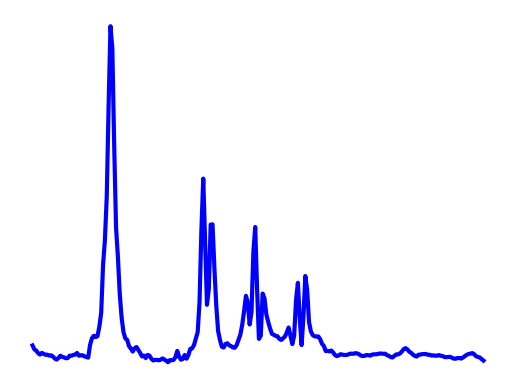

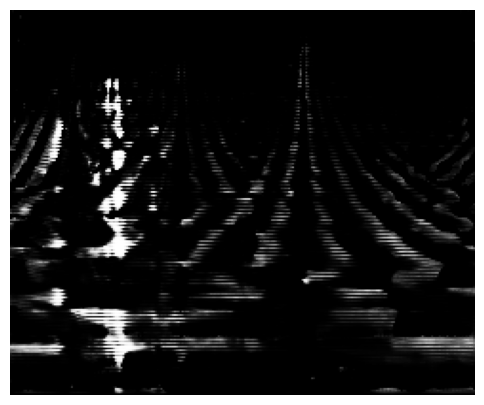

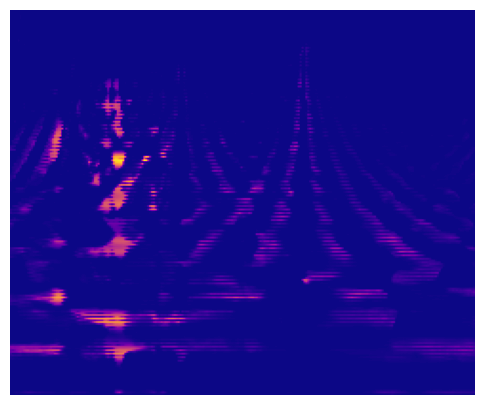

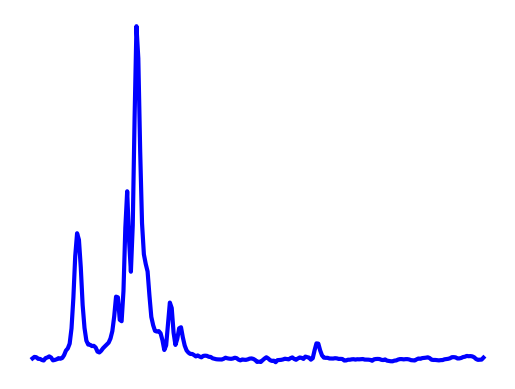

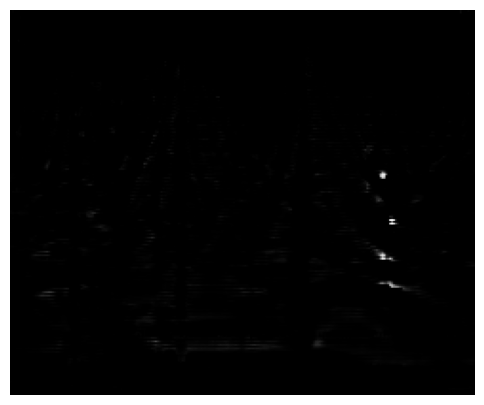

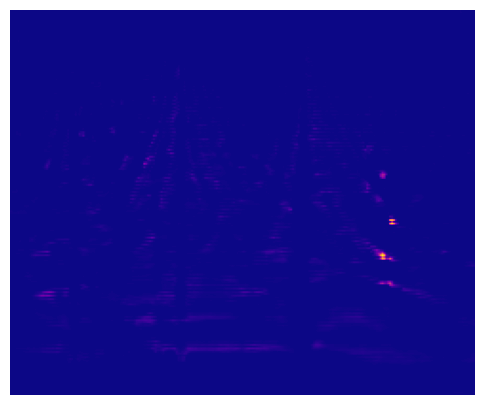

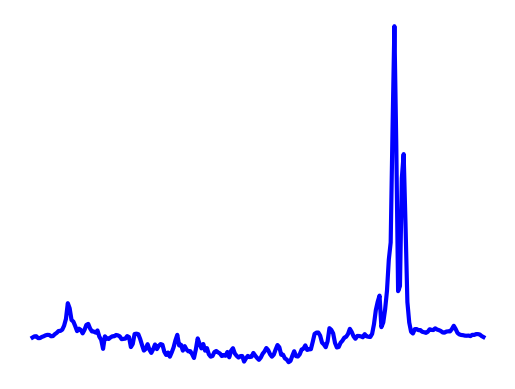

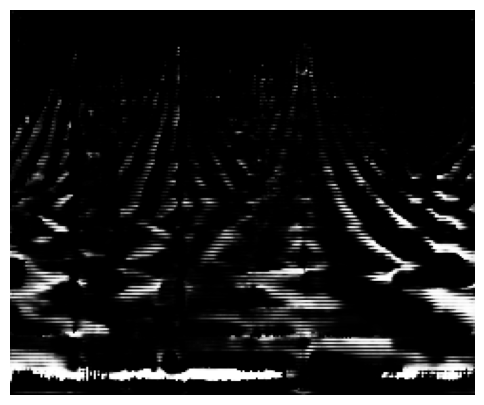

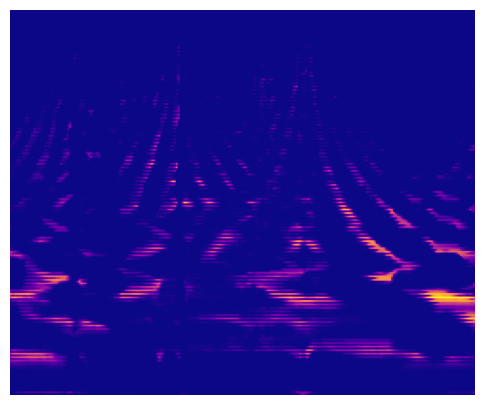

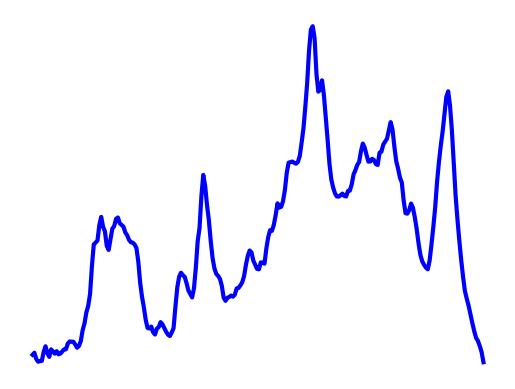

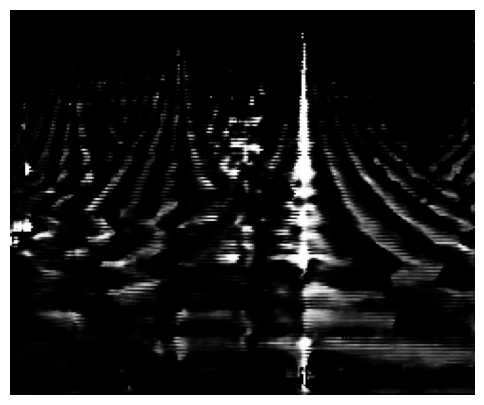

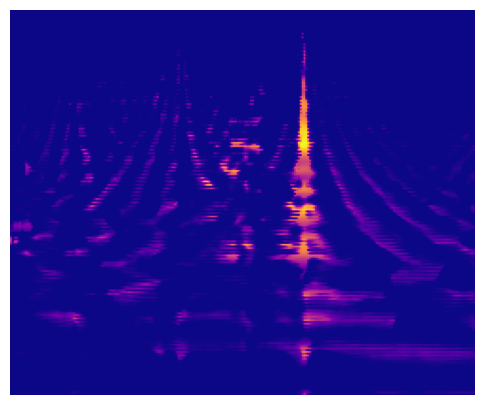

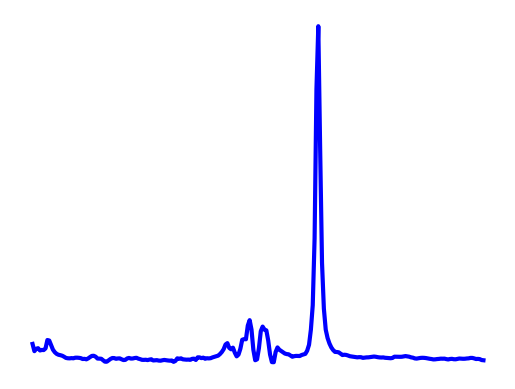

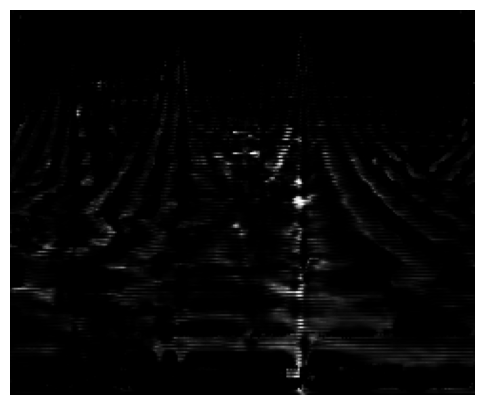

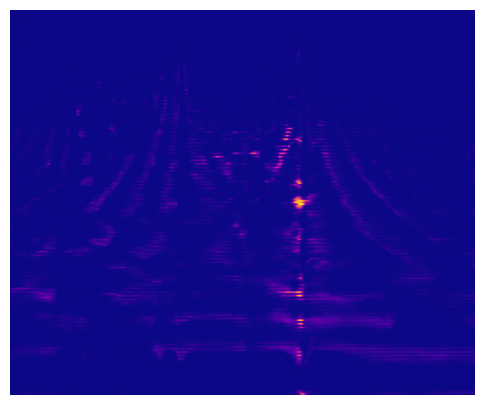

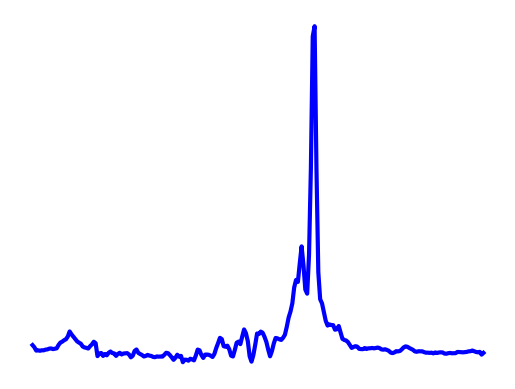

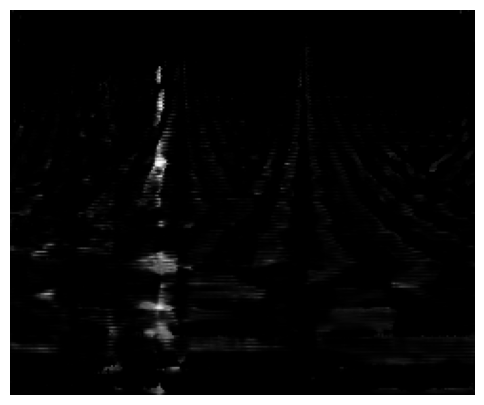

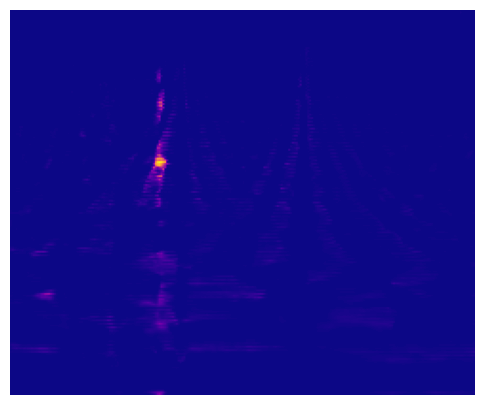

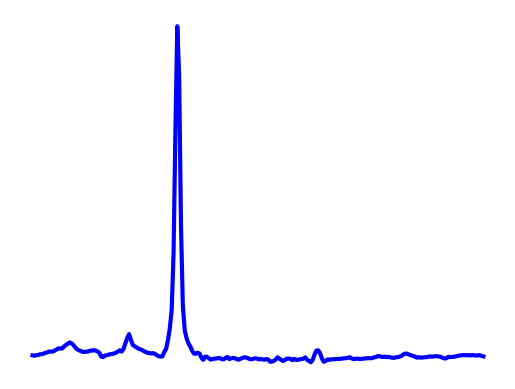

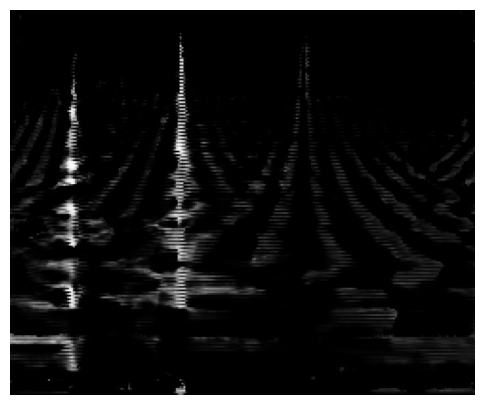

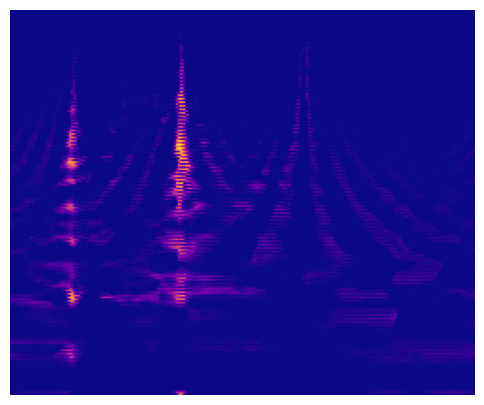

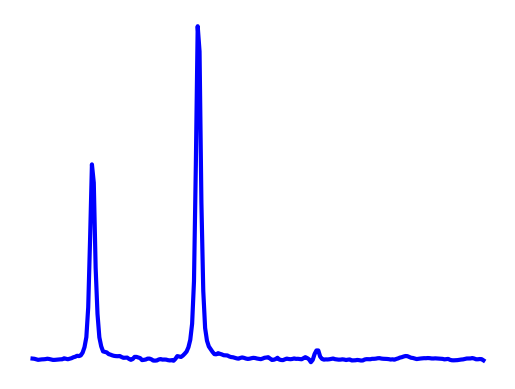

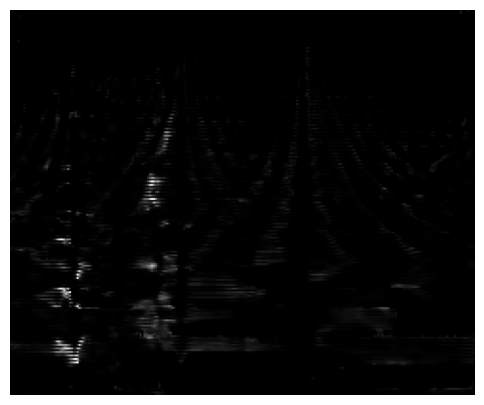

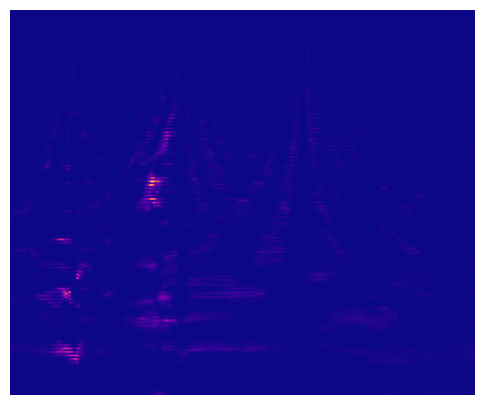

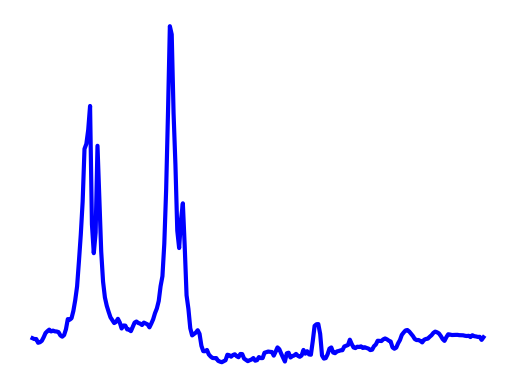

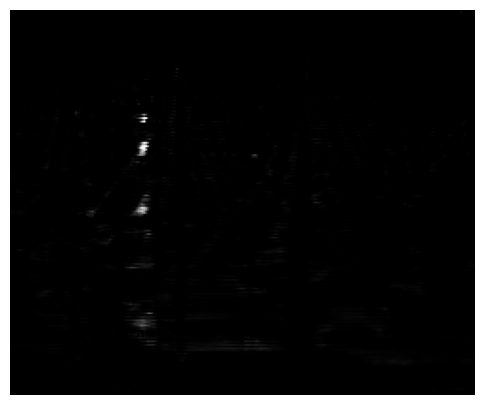

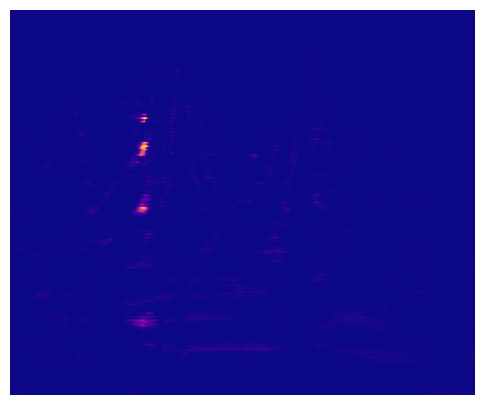

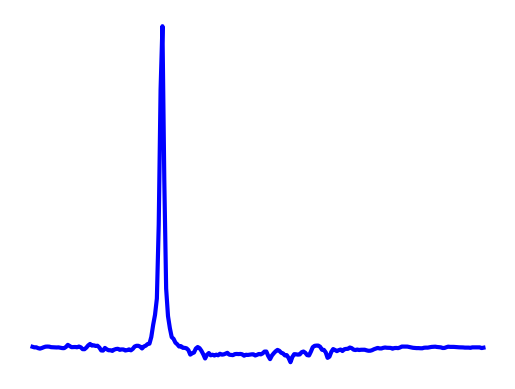

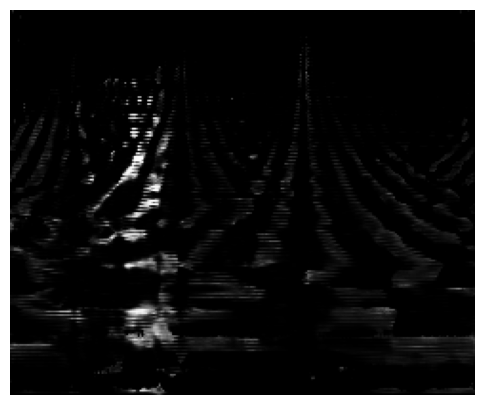

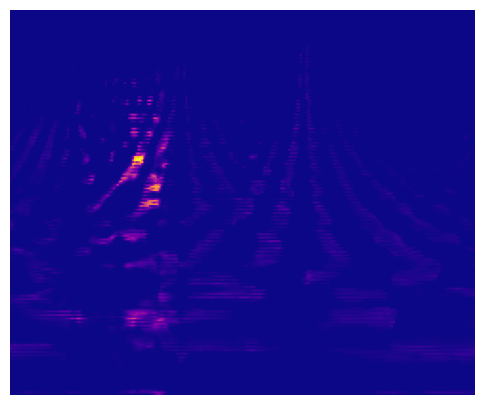

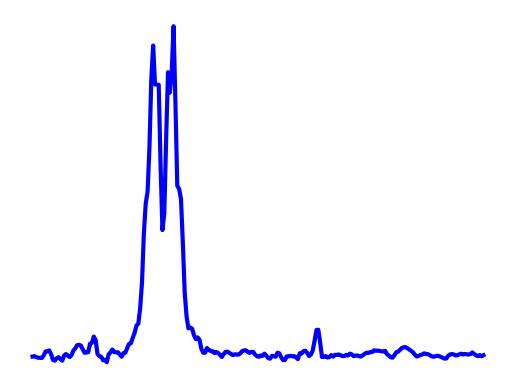

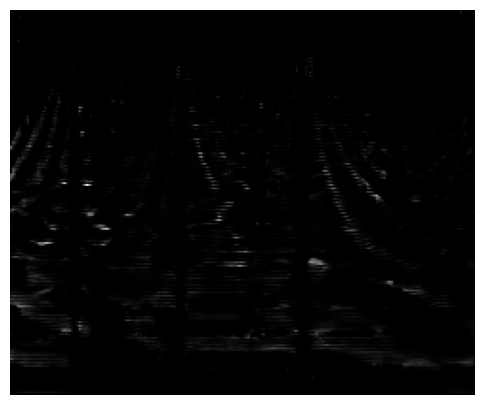

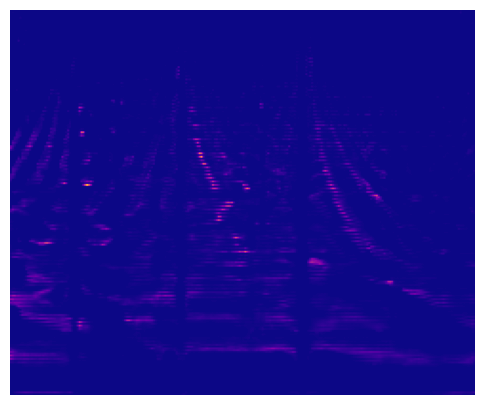

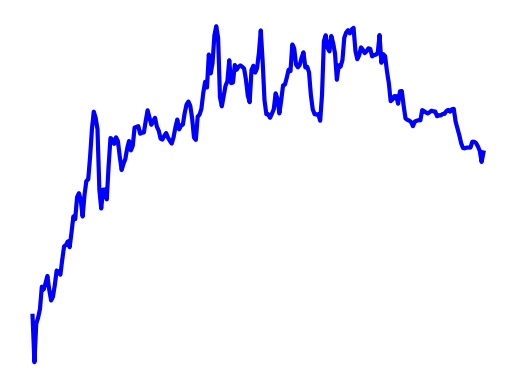

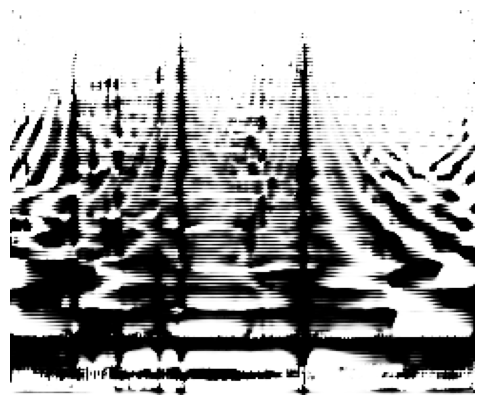

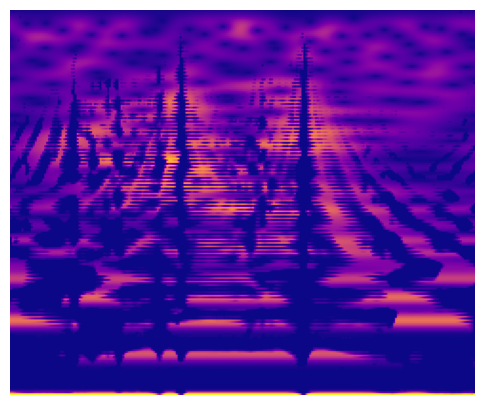

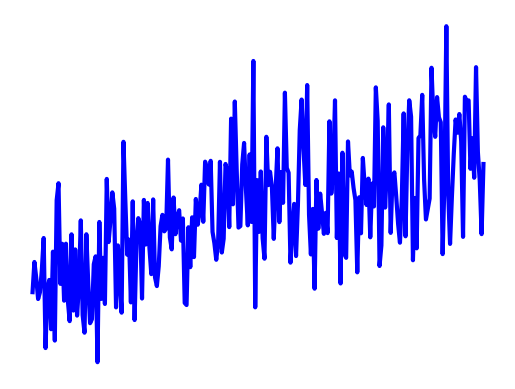

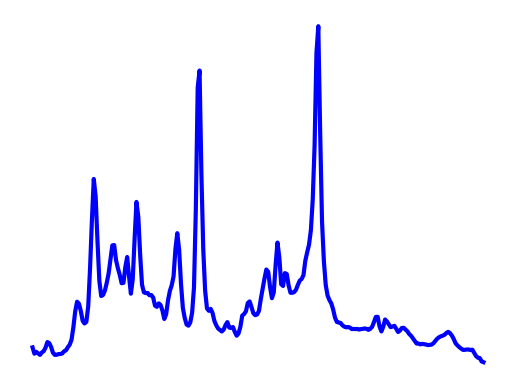

In [7]:
# plot thoroughly the scalograms, masks, and metabolite spectra
visualize_pred(xs, cwtmatr, masks, y_hat, model.names, 
               imag=config.imag, batch_idx=config.idx, metab_idx=config.metIdx)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


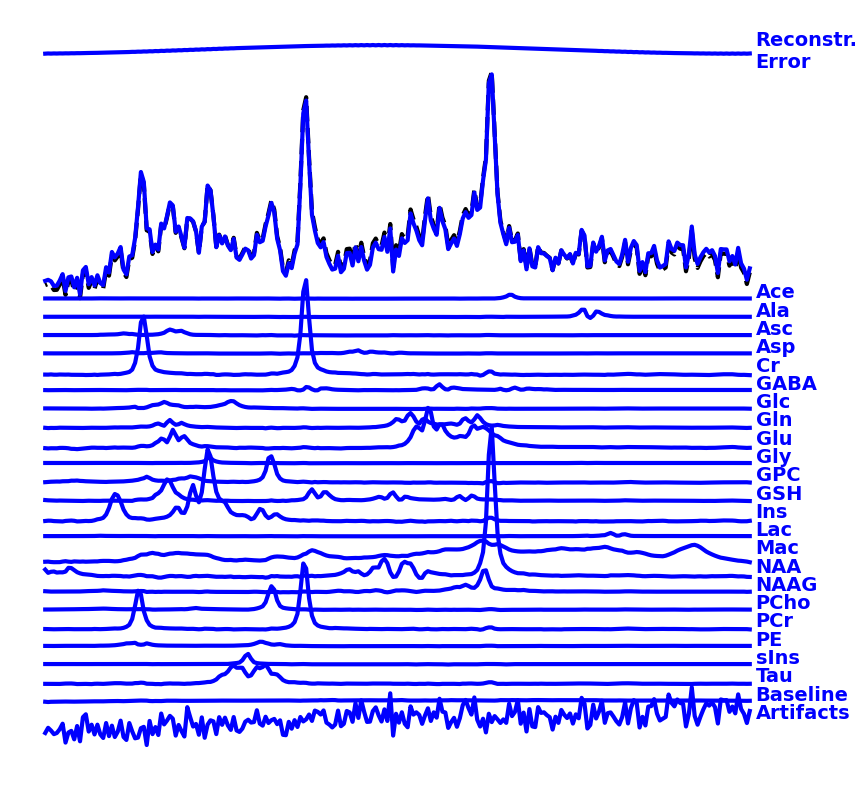

In [8]:
# plot decomposition in one figure
plot_decomposition(xs, y_hat, model.names, imag=config.imag, batch_idx=config.idx, yLim=False)

## Quantification
Below the wrapper for the FSL-MRS fitting method is initialized and the DC component is removed from all signals of the basis set.

In [9]:
# lcm method
if config.method.lower() == 'newton' or config.method.lower() == 'mh':
    lcm = FrameworkFSL(config['path2basis'], method=config.method,
                       specType=config.specType, dataType=config.dataType,
                       basisFmt=config.basisFmt, device=model.device)
elif config.method.lower() == 'lcmodel':
    lcm = FrameworkLCModel(config['path2basis'], specType=config.specType,
                           dataType=config.dataType, basisFmt=config.basisFmt,
                           device=model.device)
else:
    raise ValueError('Method not recognized.')

# remove mean from basis
lcm.basisFSL._raw_fids -= lcm.basisFSL._raw_fids.mean(-2, keepdims=True)

Most linear combination model fitting methods assume the full ppm range is present in the signal, then crops out the desired range, e.g. (0.5, 4.2) ppm, therefore we need to pad back to the original signal legth.

In [10]:
# pad back to original length
y_hat = torch.nn.functional.pad(y_hat, (0, 0, model.first, model.basisObj.n - model.last), mode='replicate')

# cut and pad back for other signals to remove issues with boundary regions
xs = xn[:, :, model.first:model.last:model.skip]
ys = yn[:, :, model.first:model.last:model.skip]

xl = torch.nn.functional.pad(xs, (model.first, model.basisObj.n - model.last), mode='replicate')
yl = torch.nn.functional.pad(ys, (0, 0, model.first, model.basisObj.n - model.last), mode='replicate')

# remove artifact channel
xc = xl - y_hat[..., -1]

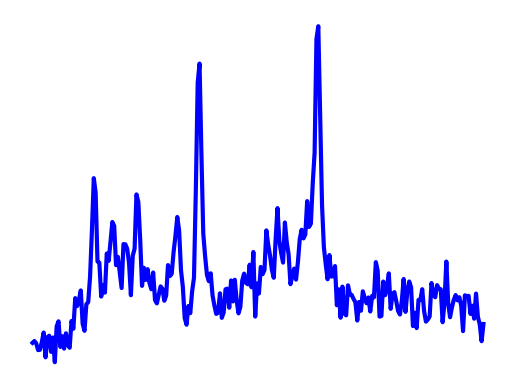

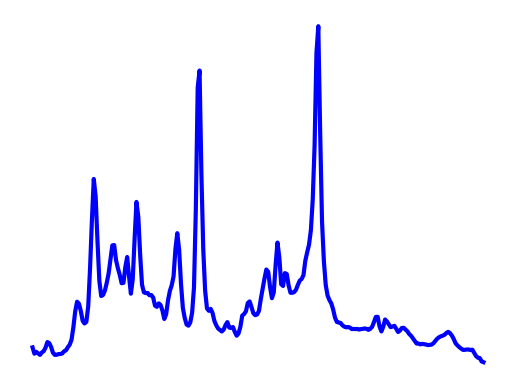

In [11]:
# plot input and clean spectrum
for i in config.idx: 
    plot_spectra(x[i, :, model.first:model.last])
    plot_spectra(xc[i, :, model.first:model.last])

Quantification is run on the unaltered spectra as well as the spectra with the artifact removed, and the resutls are subsequently compared.

lcm error: 0.4530203337754833
lcm_l error: 0.4619889589850264
lcm_c error: 0.31966975081120524


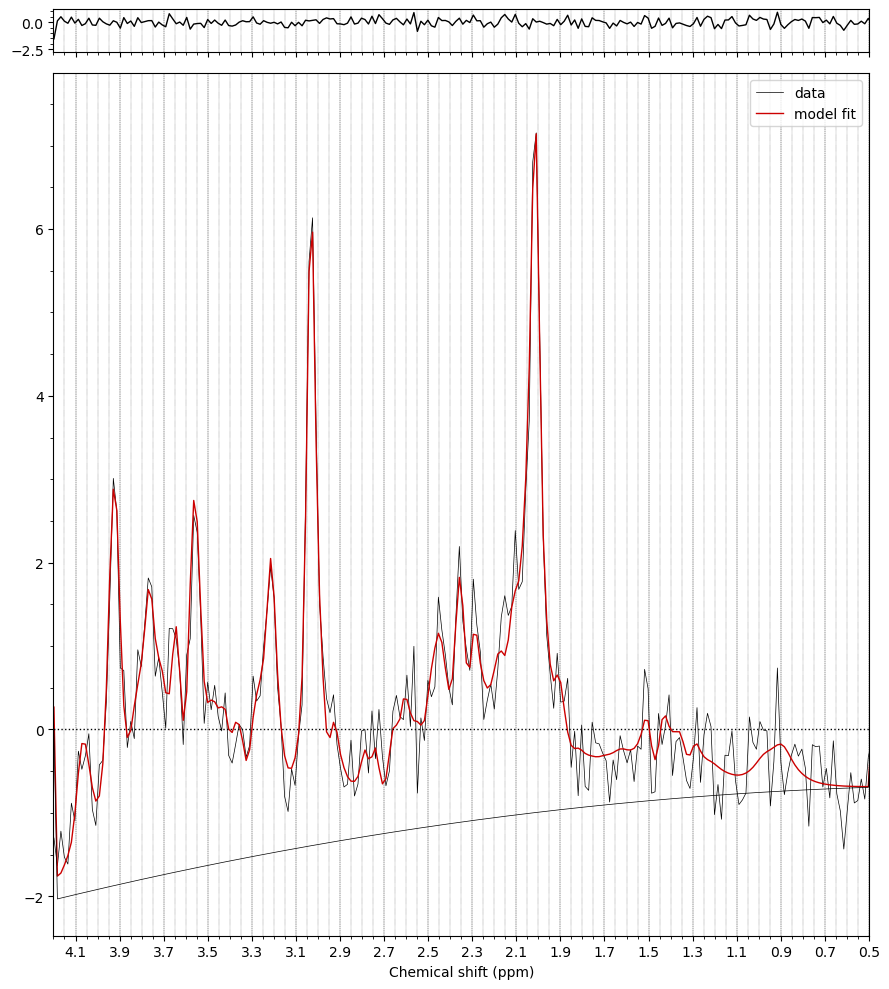

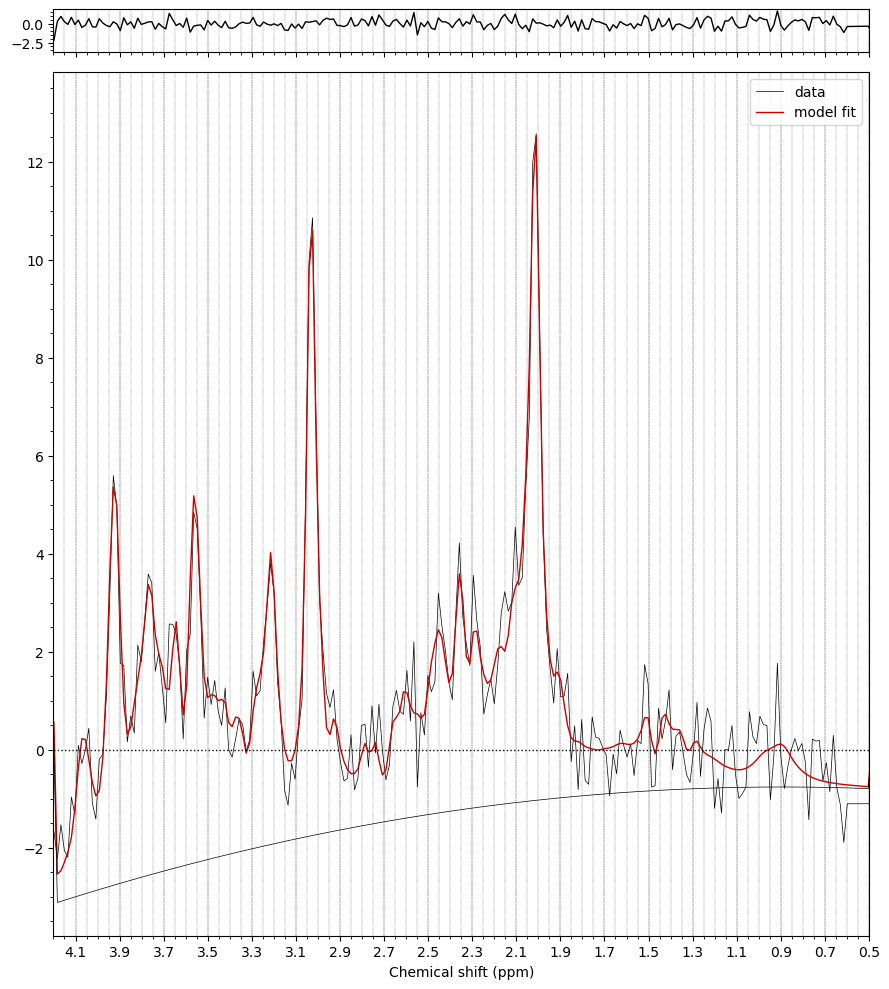

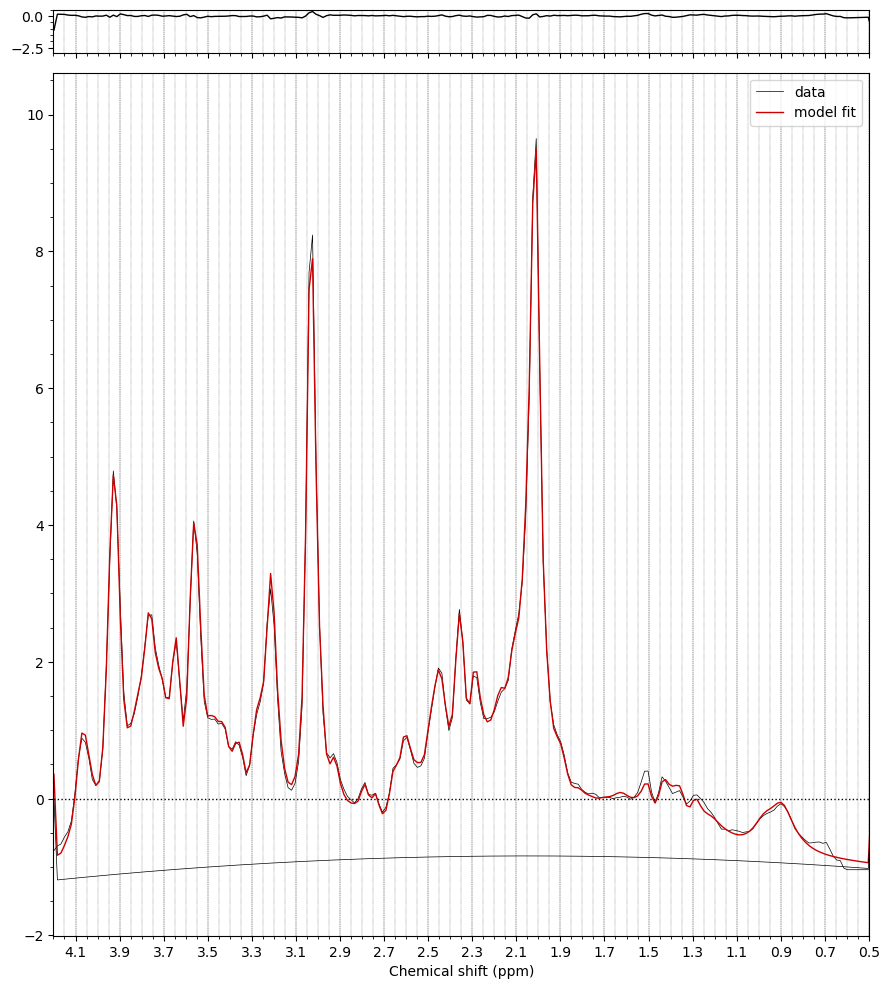

In [12]:
# get the normal lcm quantification
lcm.save_path = './tmp/lcm/'
t_lcm, u_lcm = lcm.forward(x)
lcm.save_path = './tmp/lcm_l/'
t_lcm_l, u_lcm_l = lcm.forward(xl)

# get lcm quantification without artifact signal
lcm.save_path = './tmp/lcm_c/'
t_lcm_c, u_lcm_c = lcm.forward(xc)

# print results
print('lcm error:', model.concsLoss(t, t_lcm).mean().item())
print('lcm_l error:', model.concsLoss(t, t_lcm_l).mean().item())
print('lcm_c error:', model.concsLoss(t, t_lcm_c).mean().item())

In [13]:
if config.method.lower() == 'lcmodel' and lcm.save_path != '':
    # convert output ps scripts to pdf
    import aspose.pdf as ap
    for meth in ['lcm', 'lcm_l', 'lcm_c']:
        for i in range(x.shape[0]):
            doc = ap.Document(f'./tmp/{meth}/temp{i}.ps', ap.PsLoadOptions())
            doc.save(f'./tmp/{meth}/temp{i}.pdf')

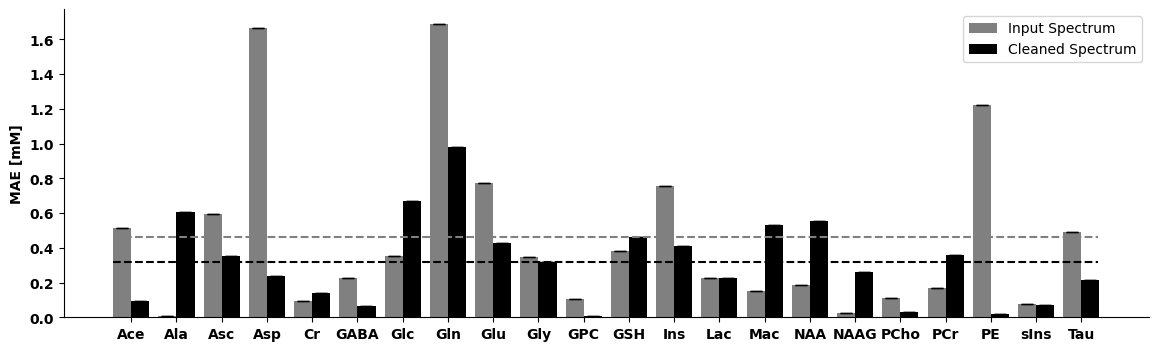

In [14]:
# plot and print results for idx
error = model.concsLoss(t, t_lcm_l).numpy()
error_c = model.concsLoss(t, t_lcm_c).numpy()

for i in config.idx:
    plot_bars_2metrics(error[i:i+1], error_c[i:i+1], lcm.basisObj.names[:lcm.basisObj.n_metabs],
                       yLabel='MAE [mM]', label1='Input Spectrum', label2='Cleaned Spectrum',
                       color1='grey', color2='black')